<a href="https://colab.research.google.com/github/alonacode/AI/blob/main/My_DZ_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Завдання

* Створіть Reader
* Створіть датасет та розділіть його на тренувальні та тестові дані
* Виберіть метрики для поріняння якості моделей
* На основі метрик виберіть найкращу модель



In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/main/module7/data/ratings.csv")

df.head()

,user_id,movie_id,rating,timestamp
0,172,94969,5.0,1396067836
1,172,98956,4.0,1396067879
2,176,73881,4.0,1499807147
3,221,1900,4.5,1288550866
4,333,33688,4.0,1412015122


In [ ]:
df.describe()

,user_id,movie_id,rating,timestamp
count,17604.000000,17604.000000,17604.000000,1.760400e+04
mean,141251.609009,88913.605942,3.465945,1.403256e+09
std,81731.882435,51285.238375,1.203144,1.515083e+08
min,172.000000,139.000000,0.500000,8.282224e+08
25%,71256.000000,55098.000000,3.000000,1.395695e+09
50%,138487.000000,89554.000000,3.500000,1.456552e+09
75%,210264.500000,134779.500000,4.500000,1.494418e+09
max,283195.000000,193843.000000,5.000000,1.537934e+09


In [ ]:
!pip install -q surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from surprise import Dataset, SVD, Reader

reader = Reader(rating_scale=(0.5, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[["user_id", "movie_id", "rating"]], reader)
data

In [ ]:
from surprise.model_selection import train_test_split

trainset, testset = train_test_split(data, train_size=0.8)

In [ ]:
from surprise import BaselineOnly

bsl_options = {'method': 'als',
               'reg_u': 0.0001,
               'reg_i': 0.0001}

algo = BaselineOnly(bsl_options=bsl_options)
algo.fit(trainset)

Estimating biases using als...


In [ ]:
from surprise import SVD

alfo = SVD(n_factors=100,
           n_epochs=50,
           )

algo.fit(trainset)

Estimating biases using als...


In [ ]:
from surprise import KNNBasic

algo = KNNBasic(k=10,
                min_k=1,
                sim_options={'name': 'cosine',
                             'user_based': True})

algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [ ]:
from surprise import CoClustering

algo = CoClustering(n_cltr_u = 5,
                    n_cltr_i = 15,
                    n_epochs = 40)

algo.fit(trainset)

In [ ]:
from surprise import BaselineOnly, accuracy


bsl_options = {'method': 'als',
               'reg_u': 0.0001,
               'reg_i': 0.0001}

algo = BaselineOnly(bsl_options=bsl_options)
algo.fit(trainset)

preds = algo.test(testset)

print(f"mae = {accuracy.mae(preds, verbose=False)}")
print(f"mse = {accuracy.mse(preds, verbose=False)}")
print(f"rmse= {accuracy.rmse(preds, verbose=False)}")
print(f"fcp = {accuracy.fcp(preds, verbose=False)}")

Estimating biases using als...
mae = 0.674813365292633
mse = 0.8644716984110157
rmse= 0.9297697018138501
fcp = 0.6241276414347482


In [ ]:
algo.predict(uid=2,
             iid=97)

Prediction(uid=2, iid=97, r_ui=None, est=3.4671944898104097, details={'was_impossible': False})

In [ ]:
# Ініціалізація моделей
models = {
    "SVD": SVD(),
    "BaselineOnly": BaselineOnly(),
    "KNNBasic": KNNBasic()
}

# Тестування моделей
results = {}
for model_name, model in models.items():
    model.fit(trainset)  # Навчання
    predictions = model.test(testset)  # Тестування

    # Оцінка якості
    rmse = accuracy.rmse(predictions, verbose=False)
    mae = accuracy.mae(predictions, verbose=False)

    results[model_name] = {"RMSE": rmse, "MAE": mae}

# Виведення результатів
for model_name, metrics in results.items():
    print(f"{model_name}: RMSE = {metrics['RMSE']:.4f}, MAE = {metrics['MAE']:.4f}")


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
SVD: RMSE = 0.9772, MAE = 0.7320
BaselineOnly: RMSE = 0.9941, MAE = 0.7474
KNNBasic: RMSE = 1.0560, MAE = 0.7989


In [ ]:
import optuna
def objective(trial):
    # Налаштування параметрів
    n_factors = trial.suggest_int("n_factors", 10, 100)
    n_epochs = trial.suggest_int("n_epochs", 10, 50)
    lr_all = trial.suggest_float("lr_all", 0.001, 0.1, log=True)
    reg_all = trial.suggest_float("reg_all", 0.01, 0.1, log=True)

    # Модель із параметрами
    model = SVD(n_factors=n_factors, n_epochs=n_epochs, lr_all=lr_all, reg_all=reg_all)

    # Навчання та тестування
    model.fit(trainset)
    predictions = model.test(testset)

    # Використовуємо RMSE як функцію втрат
    return accuracy.rmse(predictions, verbose=False)

# Запуск Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Найкращі параметри
print("Найкращі параметри:", study.best_params)

[I 2024-11-28 16:41:27,748] A new study created in memory with name: no-name-65f78dcc-ea92-4b5b-8a63-0acf85f3b1c8
[I 2024-11-28 16:41:28,182] Trial 0 finished with value: 0.9404775940193535 and parameters: {'n_factors': 44, 'n_epochs': 46, 'lr_all': 0.041051364443687455, 'reg_all': 0.027037895597506526}. Best is trial 0 with value: 0.9404775940193535.
[I 2024-11-28 16:41:28,520] Trial 1 finished with value: 0.9452876798165836 and parameters: {'n_factors': 18, 'n_epochs': 49, 'lr_all': 0.013864280268924866, 'reg_all': 0.0407710529251097}. Best is trial 0 with value: 0.9404775940193535.
[I 2024-11-28 16:41:28,960] Trial 2 finished with value: 0.9405230735373816 and parameters: {'n_factors': 51, 'n_epochs': 47, 'lr_all': 0.0051564307960889795, 'reg_all': 0.059135664925242935}. Best is trial 0 with value: 0.9404775940193535.
[I 2024-11-28 16:41:29,192] Trial 3 finished with value: 0.9496039154303243 and parameters: {'n_factors': 82, 'n_epochs': 16, 'lr_all': 0.010195202735406196, 'reg_all'

Найкращі параметри: {'n_factors': 55, 'n_epochs': 23, 'lr_all': 0.028271213284940935, 'reg_all': 0.09878427122248658}


In [ ]:
# Створюємо модель із найкращими параметрами
best_params = study.best_params
best_model = SVD(**best_params)

# Навчання та тестування
best_model.fit(trainset)
best_predictions = best_model.test(testset)

# Фінальна оцінка
final_rmse = accuracy.rmse(best_predictions)
final_mae = accuracy.mae(best_predictions)

print(f"Фінальний RMSE: {final_rmse:.4f}")
print(f"Фінальний MAE: {final_mae:.4f}")

RMSE: 0.9239
MAE:  0.6919
Фінальний RMSE: 0.9239
Фінальний MAE: 0.6919


In [ ]:
from optuna.visualization import plot_optimization_history

# Створення та відображення графіка
fig = plot_optimization_history(study)
fig.show()  # Для Jupyter Notebook

In [ ]:
from optuna.visualization import plot_param_importances

# Створення та відображення графіка
fig = plot_param_importances(study)
fig.show()

In [ ]:
from optuna.visualization import plot_slice

# Створення та відображення графіка
fig = plot_slice(study)
fig.show()

In [25]:
from optuna.visualization import plot_contour

fig = plot_contour(study)
fig.show()

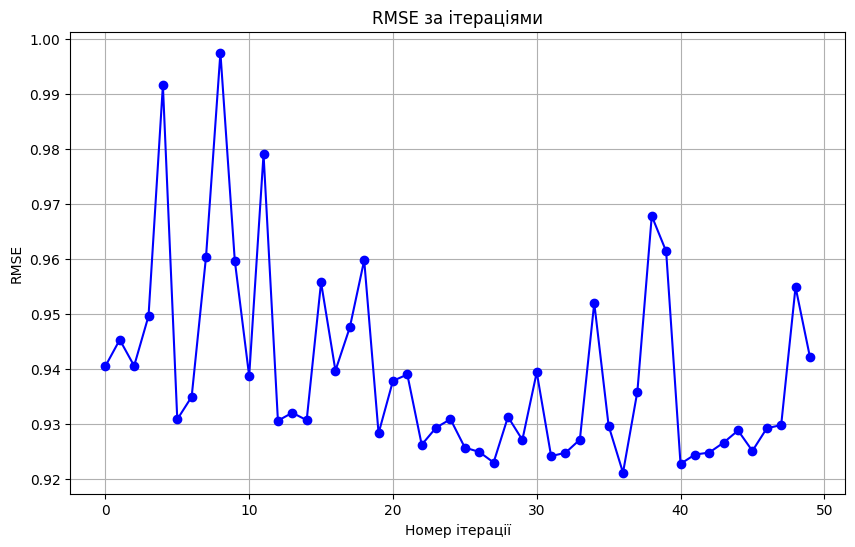

In [26]:
import matplotlib.pyplot as plt

# Дані для графіка
trials = study.trials
iterations = [trial.number for trial in trials if trial.state == optuna.trial.TrialState.COMPLETE]
rmse_values = [trial.value for trial in trials if trial.state == optuna.trial.TrialState.COMPLETE]

# Створення графіка
plt.figure(figsize=(10, 6))
plt.plot(iterations, rmse_values, marker='o', linestyle='-', color='b')
plt.title('RMSE за ітераціями')
plt.xlabel('Номер ітерації')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()
